In [1]:
data <- read.csv("new_chr19_static_classified.csv")

high_sub <- data[data$cata == 3, c("binID", "start", "aRead")]
names(high_sub) <- c("binID", "start", "high")
# head(high_sub)
medium_sub <- data[data$cata == 2, c("binID", "start", "aRead")]
names(medium_sub) <- c("binID", "start", "medium")
# head(medium_sub)
low_sub <- data[data$cata == 1, c("binID", "start", "aRead")]
names(low_sub) <- c("binID", "start", "low")
# head(low_sub)

# merge
clusterdf <- merge(high_sub, medium_sub, all = TRUE)
clusterdf <- merge(clusterdf, low_sub, all = TRUE)
clusterdf <- clusterdf[order(as.numeric(clusterdf$start)),]
clusterdf[is.na(clusterdf)] <- 0
head(clusterdf,10)

,binID,start,high,medium,low
13719,chr19_3079000,3078900,72,27,5
13722,chr19_3079600,3079500,58,10,5
13725,chr19_3079800,3079700,77,62,5
13746,chr19_3083900,3083800,6,0,0
13751,chr19_3084300,3084200,17,19,47
13759,chr19_3085800,3085700,16,18,0
13770,chr19_3087800,3087700,10,0,0
13814,chr19_3094600,3094500,127,27,7
13815,chr19_3095100,3095000,9,0,0
13818,chr19_3095300,3095200,36,16,1


In [2]:
true.clusterdf = clusterdf

In [3]:
bin.number = nrow(true.clusterdf)
bin.number

[1] 41135

In [4]:
dist_tolerance <- 100
alpha <- 0.05

In [5]:
dist.fun <- function(row) {
        dist <- as.numeric(as.character(row["start"])) - as.numeric(as.character(pre.row["start"]))
        pre.row <<- row
        return(c(row["binID"], row["start"], row["high"], row["medium"], row["low"], dist = dist)) 
    }

In [6]:
test.fun <- function(row) {
        if (as.numeric(as.character(row["start"])) - as.numeric(as.character(pre.row["start"])) > 100) {
            pre.row <<- row
            return(c(row["binID"], start = as.character(row["start"]), p.value = "0"))
        } else {
            test.matrix <- cbind(c(as.numeric(as.character(pre.row["high"])),
                                   as.numeric(as.character(pre.row["medium"])),
                                   as.numeric(as.character(pre.row["low"]))),
                                 c(as.numeric(as.character(row["high"])), 
                                   as.numeric(as.character(row["medium"])),
                                   as.numeric(as.character(row["low"]))))
            test.matrix <- test.matrix[rowSums(test.matrix) > 0, ]
            value <- suppressWarnings(chisq.test(test.matrix)$p.value)
            pre.row <<- row
            return(c(row["binID"], start = as.character(row["start"]), p.value = as.character(value)))
        }
    }

In [7]:
group.count <- function(row) {
    if ((as.numeric(as.character(row["start"])) - as.numeric(as.character(pre.row["start"]))) > 100) {
        count <<- count + 1
    }
    pre.row <<- row
}

In [9]:
result = c()
pre.row = 1
count = 0

group.func <- function(clusterdf) {   
    count <<- 0
    
    pre.row <<- clusterdf[1,]

    dist.result <- t(apply(clusterdf, 1, dist.fun))
    dist.result <- as.data.frame(dist.result)
#     head(dist.result, 30)
    
    dist.result <- dist.result[as.numeric(as.character(dist.result$dist)) <= dist_tolerance, ]
#     head(dist.result)

    dist.result <- dist.result[-1,]
#     head(dist.result)
#     nrow(dist.result)
    
    start.pos <- dist.result$start
    complete <- lapply(start.pos, function(x) c(as.numeric(as.character(x))-100, as.numeric(as.character(x))))
    complete <- Reduce(c, complete)
    complete <- unique(complete)
#     head(complete,10)
                       
    grouping <- clusterdf[as.numeric(as.character(clusterdf$start)) %in% complete, ]
    dist.result <- as.data.frame(grouping)
#     head(grouping,10)
    
    pre.row <<- dist.result[1,]

    test.result <- apply(dist.result[-1,], MARGIN = 1, FUN = test.fun)
    test.result <- t(test.result)
    test.result <- as.data.frame(test.result)
#     head(test.result)
                       
    good.result <- test.result[as.numeric(as.character(test.result$p.value)) > alpha,]
#     head(good.result)
    
    start.pos <- good.result$start
    complete <- lapply(start.pos, function(x) c(as.numeric(as.character(x))-100, as.numeric(as.character(x))))
    complete <- Reduce(c, complete)
    complete <- unique(complete)
#     head(complete,10)
                       
    grouping <- clusterdf[as.numeric(as.character(clusterdf$start)) %in% complete, ]
    grouping <- as.data.frame(grouping)
#     head(grouping,10)
                       
    pre.row <<- grouping[1,]
                       
#     head(part)
#     tail(part)
    
    invisible(apply(grouping[-1,], 1, group.count)) 
    
    result <<- c(result, count)
    
}         

In [11]:
cand = list()
for (i in 1:100) {
    clusterdf = true.clusterdf
    new.label = sample(1 : bin.number, bin.number)

    new.binID = true.clusterdf[new.label, "binID"]
    new.start = true.clusterdf[new.label, "start"]
    clusterdf[,"binID"] = new.binID
    clusterdf[,"start"] = new.start
    
    clusterdf = clusterdf[order(as.numeric(as.character(clusterdf$start))),]
#     print("sorted")
#     head(df,10)
    cand[[i]] = clusterdf
}

,binID,start,high,medium,low
5216,chr19_3079000,3078900,59,34,12
39872,chr19_3079600,3079500,64,12,0
18855,chr19_3079800,3079700,0,0,79
4350,chr19_3083900,3083800,141,15,7
31545,chr19_3084300,3084200,263,48,7
8079,chr19_3085800,3085700,73,24,9


In [12]:
invisible(lapply(cand, group.func))

result

[1] 1498 1471 1441 1490 1469 1453 1503 1457 1492 1457 1482 1492 1445 1452 1483
 [16] 1514 1438 1463 1482 1463 1489 1413 1474 1474 1457 1477 1483 1519 1501 1498
 [31] 1467 1452 1472 1454 1436 1494 1441 1453 1520 1506 1438 1438 1480 1451 1532
 [46] 1463 1471 1481 1432 1479 1493 1474 1540 1453 1555 1453 1479 1463 1498 1500
 [61] 1458 1458 1435 1492 1487 1441 1487 1479 1487 1472 1449 1446 1495 1513 1513
 [76] 1497 1518 1460 1368 1506 1519 1539 1449 1406 1495 1501 1450 1486 1489 1457
 [91] 1544 1477 1429 1522 1501 1480 1487 1455 1483 1455 1470 1534

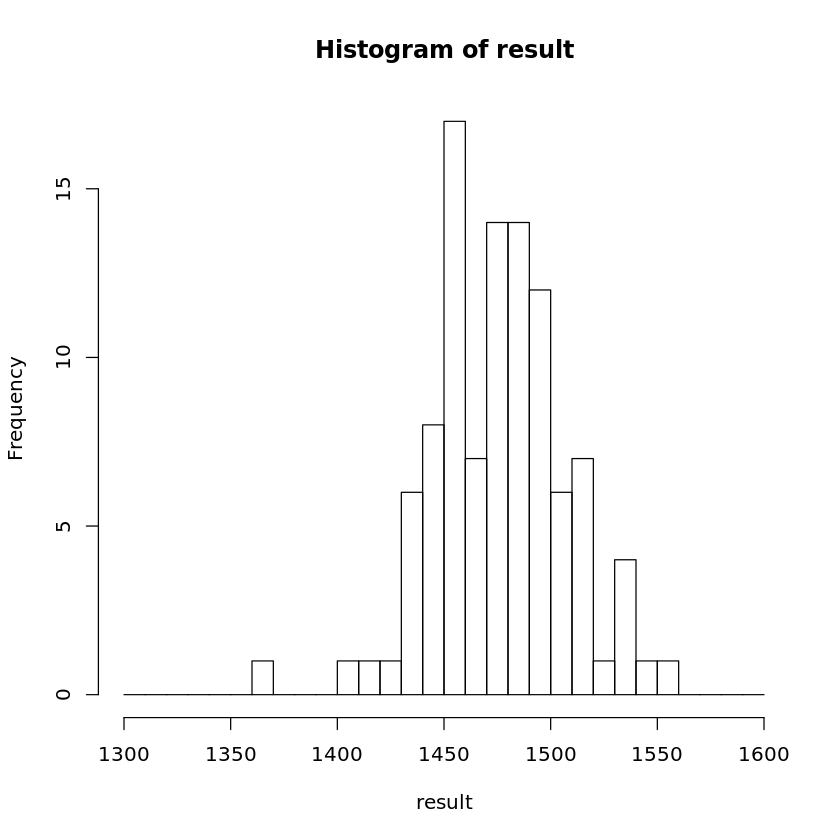

In [15]:
hist(result, breaks = seq(1300, 1600, 10))